### Boosting for classifying individuals

In [2]:
library(tidyverse)
library(gbm)
library(caret)
library(pROC)

#####  Example data

In [3]:
#bin1 = rnorm(10, 0.5, 0.2)
#bin2 = rnorm(10, 0.5, 0.2)
#bin3 = rnorm(10, 0.5, 0.2)
#bin4 = rnorm(10, 0.5, 0.2)
#bin5 = rnorm(10, 0.5, 0.2)
#bin6 = rnorm(10, 0.5, 0.2)
#bin7 = rnorm(10, 0.5, 0.2)
#bin8 = rnorm(10, 0.5, 0.2)
#bin9 = rnorm(10, 0.5, 0.2)
#bin10 = rnorm(10, 0.5, 0.2)

#lasso_pred <- as.data.frame(cbind(bin1, bin2, bin3, bin4, bin5, bin6, bin7, bin8, bin9, bin10))
#lasso_pred <- lasso_pred %>% mutate(sample_type = c(0, 1,  0, 1, 1, 0, 1, 1, 1, 0))

In [4]:
#training <- lasso_pred[4:10,]
#head(training)
#test <- lasso_pred[1:3,]
#head(test)

### Real data

In [5]:
data <- read.csv("../data/ATAC_predictions_on_all_samples_NEW/ATAC_pred_lasso_std_TRUE_formatted_standardized.csv")
#data <- data[1:100, 1:50]
head(data)

ERROR while rich displaying an object: Error in sprintf(wrap, header, body): 'fmt' length exceeds maximal format length 8192

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. 

sample,chr10_400,chr10_40,chr10_4,chr10_401,chr10_402,chr10_403,chr10_404,chr10_405,chr10_406,...,chr9_39,chr9_391,chr9_392,chr9_393,chr9_394,chr9_395,chr9_396,chr9_397,chr9_398,chr9_399
PGDX10344P1,-0.08925576,1.1121143,1.0860725,-0.9449485,-1.2125932,-0.5681915,0.9926868,1.2886064,-0.1993509,...,-0.92174235,1.05792665,-1.02305788,0.79142989,-1.30076942,-2.3457643,-0.7218696,0.2693943,0.2971029,1.1824888
PGDX10346P1,0.43553255,0.5558640,0.6594244,-0.2849241,-1.6527050,-0.6894607,0.3670987,0.5782680,-1.1018063,...,0.81819039,-0.14490999,-0.19445234,-0.28874276,-0.70864747,0.6574373,1.1024487,-0.4646219,-0.1388225,0.3311924
PGDX10349P1,-0.39026452,0.4936341,0.9167871,-0.9773439,1.1324558,-0.3715667,-1.1220223,-0.4086889,1.3079531,...,-0.93465125,-0.61166374,-1.69750944,0.02199552,-0.71294671,-0.1680186,1.3145509,1.4171486,1.0138287,0.9025277
PGDX10351P1,1.64205233,-1.6702428,0.4253308,-0.7524777,-0.6566825,-0.2754240,-0.6026120,-0.2053386,-0.1341700,...,0.06169946,0.04780256,-0.66379159,0.52906776,0.35395822,1.0417999,1.5527024,1.1290283,-0.9033571,0.5172448
PGDX10566P,-0.36631714,-1.6127632,0.5614711,-1.2810109,1.6781909,0.7640413,-0.5134529,0.5897762,0.1976925,...,0.46743688,-0.96028363,0.01758011,-0.92021861,0.09485823,0.3359649,2.6884321,-1.2113342,-1.6429364,-1.2016336
PGDX10567P,0.22376485,-0.6411306,-0.6390333,0.3552611,-0.7717650,-0.2239156,-0.1470735,0.1245092,0.5256388,...,0.71302645,0.74787090,-0.57103960,1.17298651,-2.12801779,1.3752400,-0.2524025,-0.8668343,-0.5358466,0.9187682


In [6]:
sample_types <- read.table("../data/sample_types.txt", header = F, sep = " ")
colnames(sample_types) <- c("sample", "sample_type")
head(sample_types)

sample,sample_type
PGDX10344P1,Gastric_cancer
PGDX10346P1,Gastric_cancer
PGDX10349P1,Gastric_cancer
PGDX10351P1,Gastric_cancer
PGDX10566P,Ovarian_Cancer
PGDX10567P,Ovarian_Cancer


In [7]:
dim(data)
dim(sample_types)

[1]   473 10304

[1] 473   2

In [8]:
data <- merge(data, sample_types, by="sample")
head(data)

data <- data %>% mutate(sample_type01 = ifelse(sample_type == "Healthy", 0, 1))
head(data)
                        

ERROR while rich displaying an object: Error in sprintf(wrap, header, body): 'fmt' length exceeds maximal format length 8192

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. 

sample,chr10_400,chr10_40,chr10_4,chr10_401,chr10_402,chr10_403,chr10_404,chr10_405,chr10_406,...,chr9_391,chr9_392,chr9_393,chr9_394,chr9_395,chr9_396,chr9_397,chr9_398,chr9_399,sample_type
PGDX10344P1,-0.08925576,1.1121143,1.0860725,-0.9449485,-1.2125932,-0.5681915,0.9926868,1.2886064,-0.1993509,...,1.05792665,-1.02305788,0.79142989,-1.30076942,-2.3457643,-0.7218696,0.2693943,0.2971029,1.1824888,Gastric_cancer
PGDX10346P1,0.43553255,0.5558640,0.6594244,-0.2849241,-1.6527050,-0.6894607,0.3670987,0.5782680,-1.1018063,...,-0.14490999,-0.19445234,-0.28874276,-0.70864747,0.6574373,1.1024487,-0.4646219,-0.1388225,0.3311924,Gastric_cancer
PGDX10349P1,-0.39026452,0.4936341,0.9167871,-0.9773439,1.1324558,-0.3715667,-1.1220223,-0.4086889,1.3079531,...,-0.61166374,-1.69750944,0.02199552,-0.71294671,-0.1680186,1.3145509,1.4171486,1.0138287,0.9025277,Gastric_cancer
PGDX10351P1,1.64205233,-1.6702428,0.4253308,-0.7524777,-0.6566825,-0.2754240,-0.6026120,-0.2053386,-0.1341700,...,0.04780256,-0.66379159,0.52906776,0.35395822,1.0417999,1.5527024,1.1290283,-0.9033571,0.5172448,Gastric_cancer
PGDX10566P,-0.36631714,-1.6127632,0.5614711,-1.2810109,1.6781909,0.7640413,-0.5134529,0.5897762,0.1976925,...,-0.96028363,0.01758011,-0.92021861,0.09485823,0.3359649,2.6884321,-1.2113342,-1.6429364,-1.2016336,Ovarian_Cancer
PGDX10567P,0.22376485,-0.6411306,-0.6390333,0.3552611,-0.7717650,-0.2239156,-0.1470735,0.1245092,0.5256388,...,0.74787090,-0.57103960,1.17298651,-2.12801779,1.3752400,-0.2524025,-0.8668343,-0.5358466,0.9187682,Ovarian_Cancer


ERROR while rich displaying an object: Error in sprintf(wrap, header, body): 'fmt' length exceeds maximal format length 8192

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. 

sample,chr10_400,chr10_40,chr10_4,chr10_401,chr10_402,chr10_403,chr10_404,chr10_405,chr10_406,...,chr9_392,chr9_393,chr9_394,chr9_395,chr9_396,chr9_397,chr9_398,chr9_399,sample_type,sample_type01
PGDX10344P1,-0.08925576,1.1121143,1.0860725,-0.9449485,-1.2125932,-0.5681915,0.9926868,1.2886064,-0.1993509,...,-1.02305788,0.79142989,-1.30076942,-2.3457643,-0.7218696,0.2693943,0.2971029,1.1824888,Gastric_cancer,1
PGDX10346P1,0.43553255,0.5558640,0.6594244,-0.2849241,-1.6527050,-0.6894607,0.3670987,0.5782680,-1.1018063,...,-0.19445234,-0.28874276,-0.70864747,0.6574373,1.1024487,-0.4646219,-0.1388225,0.3311924,Gastric_cancer,1
PGDX10349P1,-0.39026452,0.4936341,0.9167871,-0.9773439,1.1324558,-0.3715667,-1.1220223,-0.4086889,1.3079531,...,-1.69750944,0.02199552,-0.71294671,-0.1680186,1.3145509,1.4171486,1.0138287,0.9025277,Gastric_cancer,1
PGDX10351P1,1.64205233,-1.6702428,0.4253308,-0.7524777,-0.6566825,-0.2754240,-0.6026120,-0.2053386,-0.1341700,...,-0.66379159,0.52906776,0.35395822,1.0417999,1.5527024,1.1290283,-0.9033571,0.5172448,Gastric_cancer,1
PGDX10566P,-0.36631714,-1.6127632,0.5614711,-1.2810109,1.6781909,0.7640413,-0.5134529,0.5897762,0.1976925,...,0.01758011,-0.92021861,0.09485823,0.3359649,2.6884321,-1.2113342,-1.6429364,-1.2016336,Ovarian_Cancer,1
PGDX10567P,0.22376485,-0.6411306,-0.6390333,0.3552611,-0.7717650,-0.2239156,-0.1470735,0.1245092,0.5256388,...,-0.57103960,1.17298651,-2.12801779,1.3752400,-0.2524025,-0.8668343,-0.5358466,0.9187682,Ovarian_Cancer,1


In [9]:
#data %>% filter(sample_type == "Healthy")

data <- data %>% select(-sample_type)

In [10]:
data <- data %>% select(-sample)
head(data)

ERROR while rich displaying an object: Error in sprintf(wrap, header, body): 'fmt' length exceeds maximal format length 8192

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. 

chr10_400,chr10_40,chr10_4,chr10_401,chr10_402,chr10_403,chr10_404,chr10_405,chr10_406,chr10_407,...,chr9_391,chr9_392,chr9_393,chr9_394,chr9_395,chr9_396,chr9_397,chr9_398,chr9_399,sample_type01
-0.08925576,1.1121143,1.0860725,-0.9449485,-1.2125932,-0.5681915,0.9926868,1.2886064,-0.1993509,1.7510626,...,1.05792665,-1.02305788,0.79142989,-1.30076942,-2.3457643,-0.7218696,0.2693943,0.2971029,1.1824888,1
0.43553255,0.5558640,0.6594244,-0.2849241,-1.6527050,-0.6894607,0.3670987,0.5782680,-1.1018063,-0.1956803,...,-0.14490999,-0.19445234,-0.28874276,-0.70864747,0.6574373,1.1024487,-0.4646219,-0.1388225,0.3311924,1
-0.39026452,0.4936341,0.9167871,-0.9773439,1.1324558,-0.3715667,-1.1220223,-0.4086889,1.3079531,-0.7064974,...,-0.61166374,-1.69750944,0.02199552,-0.71294671,-0.1680186,1.3145509,1.4171486,1.0138287,0.9025277,1
1.64205233,-1.6702428,0.4253308,-0.7524777,-0.6566825,-0.2754240,-0.6026120,-0.2053386,-0.1341700,-0.0461431,...,0.04780256,-0.66379159,0.52906776,0.35395822,1.0417999,1.5527024,1.1290283,-0.9033571,0.5172448,1
-0.36631714,-1.6127632,0.5614711,-1.2810109,1.6781909,0.7640413,-0.5134529,0.5897762,0.1976925,0.1170861,...,-0.96028363,0.01758011,-0.92021861,0.09485823,0.3359649,2.6884321,-1.2113342,-1.6429364,-1.2016336,1
0.22376485,-0.6411306,-0.6390333,0.3552611,-0.7717650,-0.2239156,-0.1470735,0.1245092,0.5256388,0.2008443,...,0.74787090,-0.57103960,1.17298651,-2.12801779,1.3752400,-0.2524025,-0.8668343,-0.5358466,0.9187682,1


+ Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=1, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=2, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=3, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=4, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=5, n.minobsinnode=10, n.trees=600 
+ Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.trees=600 
- Fold01.Rep1: shrinkage=0.01, interaction.depth=6, n.minobsinnode=10, n.tre

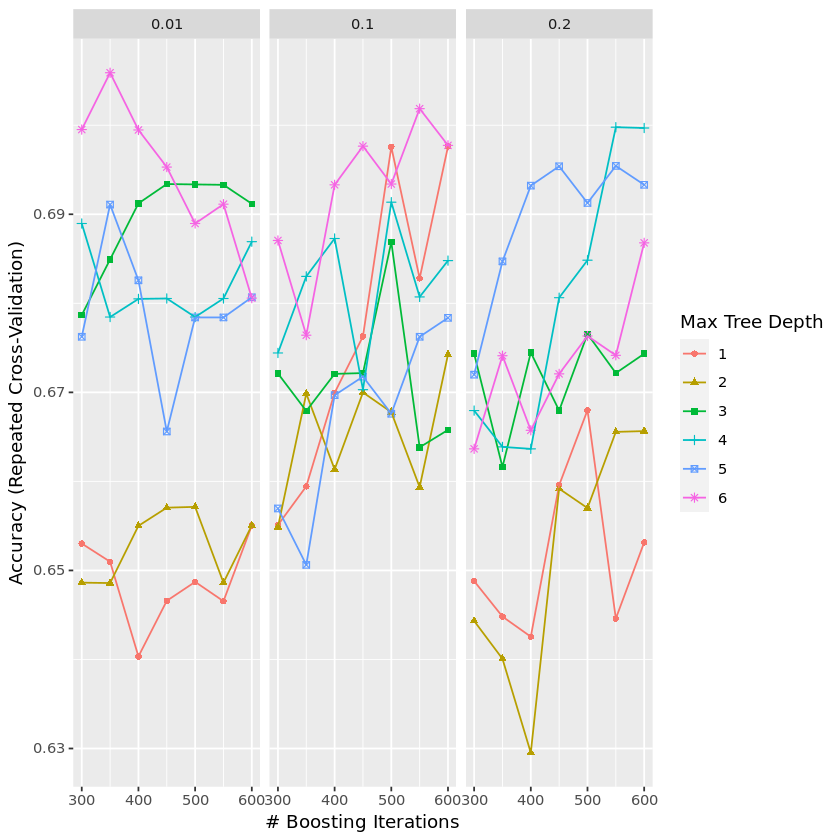

In [11]:
training_x <- data %>% dplyr::select(-sample_type01) %>% as.data.frame()
training_y <- as.factor(data$sample_type01)

#___________________________________________________________________________________

# seeds lengths = number of models*number of repeats *number of folds + 1
set.seed(1)
seeds_gbm <- vector(mode = "list", length = 71)
# each seed list is a length of the tuning
for(i in 1:70) seeds_gbm[[i]] <- sample.int(1000, 18)
## For the last model:
seeds_gbm[[71]] <- sample.int(1000, 1)

trControl_gbm <- trainControl(method = "repeatedcv", 
                              number = 10, 
                              repeats = 1, 
                              verboseIter = ifelse(is.null(getOption('knitr.in.progress')), TRUE, FALSE), 
                              seeds = seeds_gbm)

gbmGrid <- expand.grid(interaction.depth = c(1, 2, 3, 4, 5, 6),
                       n.trees = seq(300, 600, 50),
                       shrinkage = c(0.1, 0.2, 0.01),
                        n.minobsinnode = c(10))


trControl <- trControl_gbm
method <- "gbm"

set.seed(1)
fit <- train(x = training_x, 
             y = training_y, 
             method = method,
             tuneGrid = gbmGrid,
             trControl = trControl, 
             verbose=F)
  
  
print(fit)
ggplot(fit)

print(mean(fit$resample$Accuracy))

In [12]:
#set.seed(0)

#fit <- gbm(formula  = sample_type01 ~ ., 
#           data = data, 
#           n.trees = 500, 
#           cv.folds = 10, 
#           distribution="bernoulli", 
#           n.minobsinnode = 10)

In [13]:
data$sample_type01 <- as.factor(data$sample_type01)

In [14]:
levels(data$sample_type01)

[1] "0" "1"

In [15]:
cross_validation <- function(dataset, k){
  
  cvfolds <- cut(seq_len(nrow(dataset)), breaks = k, labels = F)
  cvfolds <- sample(cvfolds)
  
  observed  <- dataset$sample_type01
  predicted <- rep(NA, nrow(dataset))
  
  for (i in 1:k){
    rows      <- which(cvfolds==i)
    testdata  <- dataset[rows,]
    testdata <- testdata %>% select(-sample_type01)
    testlabels <- testdata$sample_type01
    
    traindata <- dataset[-rows,]
    trainlabels <- traindata$sample_type01
    traindata <- traindata %>% select(-sample_type01)
      
      
    fitControl <- trainControl(method = "none")
    fit <- train(x = traindata, 
                 y = trainlabels,
                 method = "gbm",
                 trControl = fitControl,
                 verbose = FALSE,
                 tuneGrid = data.frame(n.trees = 350, 
                                       interaction.depth = 6,
                                       shrinkage = 0.01,
                                       n.minobsinnode = 10))
              
    
 
    predicted[rows] <- predict(fit, newdata = testdata)
  }
  
    #message(observed)
    #message(predicted)  
    #auc_result <- auc(observed, predicted)

    results <- tibble(observed = observed, predicted = predicted-1)

  return(results)
}

In [16]:
results = cross_validation(data, 10)

In [17]:
roc.plot <- roc(results$observed, results$predicted)

Setting levels: control = 0, case = 1
Setting direction: controls < cases


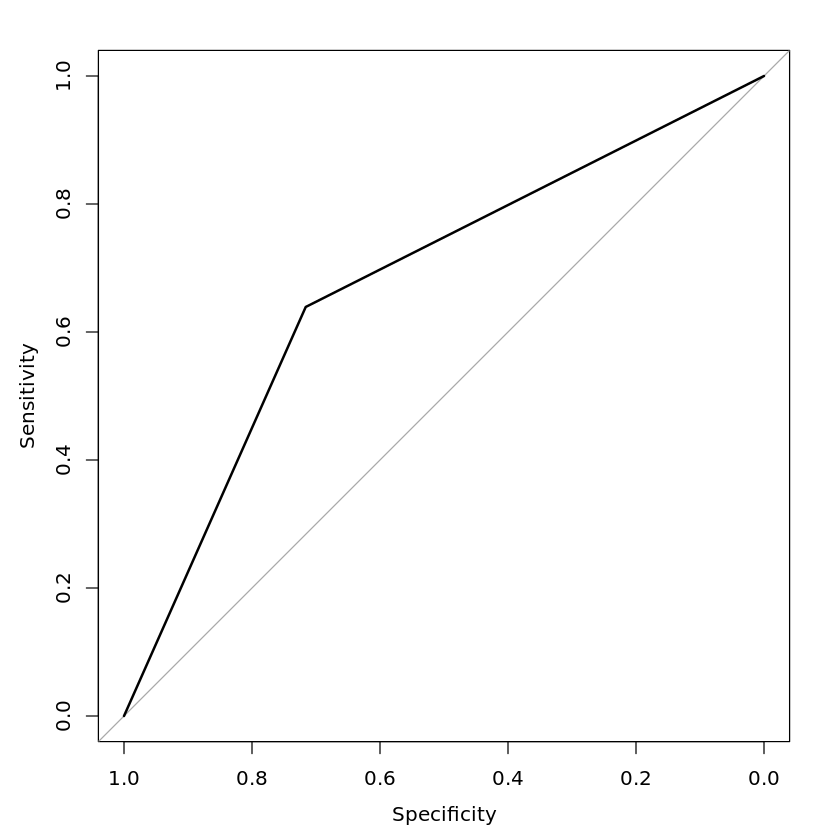

In [18]:
plot(roc.plot)

In [19]:
auc(roc.plot)

Area under the curve: 0.6776